In [1]:
import io
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import boto3
import sagemaker
from sagemaker import get_execution_role, PCA

In [2]:
session = sagemaker.Session()
print(session)

role = get_execution_role()
print(role)

bucket = session.default_bucket()

arn:aws:iam::240038582877:role/service-role/AmazonSageMaker-ExecutionRole-20191028T202433


### Customers

In [3]:
# load data
prefix = 'segmentation'

data_key= prefix + '/customers_scaled.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

In [4]:
tmp_list = []

for chunk in pd.read_csv(data_location, chunksize=100000):
    tmp_list.append(chunk)
    
df = pd.concat(tmp_list, axis=0).drop(['Unnamed: 0'], axis=1)
print(df.shape)
del tmp_list

(191652, 94)


In [5]:
df.head()

,LNR,AGER_TYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,...,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.050221,0.75,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,1.000000,...,0.166667,0.833333,0.0,0.833333,1.00,0.666667,0.4,0.0,0.0,0.375
1,0.050232,0.00,0.000000,0.166667,0.555556,0.000000,0.833333,0.000000,1.0,1.000000,...,0.166667,0.333333,0.0,1.000000,1.00,0.666667,0.4,0.0,0.0,0.375
2,0.750693,0.00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,1.000000,...,0.000000,0.166667,0.0,0.333333,0.50,1.000000,0.4,0.0,1.0,0.375
3,0.750698,0.50,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,1.000000,...,0.333333,0.833333,0.5,1.000000,0.25,0.666667,0.0,0.0,0.0,0.375
4,0.750703,0.00,0.166667,0.333333,0.222222,0.714286,0.000000,0.428571,1.0,0.666667,...,0.500000,0.500000,0.5,0.666667,0.50,1.000000,0.0,0.0,0.0,0.250


In [6]:
# prepare space to store model artifacts
prefix = 'pca'
output_path = 's3://{}/{}/'.format(bucket, prefix)
output_path

's3://sagemaker-us-east-2-240038582877/pca/'

In [7]:
N_COMPONENTS = 10
pca = PCA(role=role,
          train_instance_count=1,
          train_instance_type='ml.c4.xlarge',
          output_path=output_path,
          num_components=N_COMPONENTS,
          sagemaker_session=session)

In [8]:
#must convert to RecordSet for built in sagemaker models

#convert df to np array (pass this to the deployed PCA model later)
train_data_np = df.values.astype('float32')

#convert to RecordSet format
formatted_train_data = pca.record_set(train_data_np)

In [9]:
pca.fit(formatted_train_data)

2020-04-21 00:45:29 Starting - Starting the training job...
2020-04-21 00:45:30 Starting - Launching requested ML instances...
2020-04-21 00:46:27 Starting - Preparing the instances for training.........
2020-04-21 00:47:52 Downloading - Downloading input data
2020-04-21 00:47:52 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/21/2020 00:48:09 INFO 140720273946432] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[04/21/2020 00:48:09 INFO 140720273946432] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'94', u'mini_batch_size': u'500', u'num_components':


2020-04-21 00:48:17 Uploading - Uploading generated training model
2020-04-21 00:48:17 Completed - Training job completed
Training seconds: 36
Billable seconds: 36


In [10]:
#get from AWS console
training_job_name = 'pca-2020-04-21-00-45-29-356'
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

boto3.resource('s3').Bucket(bucket).download_file(model_key, 'model.tar.gz')

os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

pca/pca-2020-04-21-00-45-29-356/output/model.tar.gz


2304

In [13]:
!pip install mxnet
import mxnet as mx

pca_model_params = mx.ndarray.load('model_algo-1')

print(pca_model_params)

    100% |████████████████████████████████| 68.7MB 670kB/s eta 0:00:01
    100% |████████████████████████████████| 20.2MB 2.3MB/s eta 0:00:01    97% |███████████████████████████████▏| 19.6MB 13.1MB/s eta 0:00:01
fastai 1.0.60 requires nvidia-ml-py3, which is not installed.
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
{'s': 
[151.03342 157.1557  158.33104 167.0297  188.32408 193.03432 221.53874
 319.5286  337.85233 675.31635]
<NDArray 10 @cpu(0)>, 'v': 
[[-1.56262788e-04  5.86214568e-03 -3.05910781e-03 -3.08205327e-03
   2.03793729e-03 -1.74974452e-03  1.90320727e-03 -1.34209997e-03
   3.80283134e-04  5.93305740e-04]
 [-2.17574567e-01 -8.72530639e-02 -8.74040574e-02 -2.98052549e-01
  -2.02772513e-01 -1.02115884e-01 -5.94947152e-02  5.77346496e-02
  -1.71816766e-01  1.269

In [14]:
#mean - mean subtracted from a component in order to center it
#v - makeup of the principal component (same as components_)
#s - singular values of the components for the PCA transformation, % of variance from the projected future space

#explained-variance-ratio ~= square(s) / sum(square(s))

s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

n_principal_components = 5

start_idx = N_COMPONENTS - n_principal_components

print(s.iloc[start_idx:])

            0
5  193.034317
6  221.538742
7  319.528595
8  337.852325
9  675.316345


In [15]:
#what is the smallest number or principal comonents that captures at least 80% of the
#total variance in the dataset?

def explained_variance(s, n_top_components):
#     exp_variance = np.square(s.iloc[start_idx:])
    exp_variance = np.square(s.iloc[start_idx:]).sum() / np.square(s).sum()
    return exp_variance

In [16]:
n_top_components = 10
exp_variance = explained_variance(s, n_top_components)
print(exp_variance)

0    0.848037
dtype: float32


### Component Features

In [17]:
df.columns.values;

In [18]:
corr_matrix = df.corr().abs()
c2 = corr_matrix.unstack().sort_values(ascending=False).to_frame()
# set(c2[np.logical_and(c2[0] > 0.8, c2[0] < 1)].index.values)

In [19]:
corr_matrix.style.background_gradient(cmap='coolwarm');

In [20]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
        row_idx = N_COMPONENTS-component_num
        v_l_row = v.iloc[:, row_idx]
        v_1 = np.squeeze(v_l_row.values)
        
        compos = pd.DataFrame(list(zip(v_1, features_list)), columns=['weights', 'features'])
        
        # get absolute value
        #weights can be neg/pos and we'll sort by magnitude
        
        compos['abs_weights'] = compos['weights'].apply(lambda x: abs(x))
        sorted_compos = compos.sort_values('abs_weights', ascending=False).head(n_weights)
        print(sorted_compos)
        
        ax=plt.subplots(figsize=(10,6))
        ax=sns.barplot(data=sorted_compos, x="weights", y="features", palette="Blues_d")
        ax.set_title("PCA Component Makeup Component #{}".format(component_num))
        plt.show()

     weights                  features  abs_weights
51 -0.251181  D19_VERSAND_ONLINE_DATUM     0.251181
61  0.250702            FINANZ_ANLEGER     0.250702
25 -0.246789   D19_GESAMT_ONLINE_DATUM     0.246789
49 -0.231013         D19_VERSAND_DATUM     0.231013
22  0.218606         D19_GESAMT_ANZ_24     0.218606
48  0.206982        D19_VERSAND_ANZ_24     0.206982
65  0.201834     FINANZ_UNAUFFAELLIGER     0.201834
23 -0.200427          D19_GESAMT_DATUM     0.200427
64  0.199985             FINANZ_SPARER     0.199985
21  0.174527         D19_GESAMT_ANZ_12     0.174527
1  -0.171817                  AGER_TYP     0.171817
66 -0.163243          FINANZ_VORSORGER     0.163243
84  0.160754                 SEMIO_REL     0.160754
47  0.158402        D19_VERSAND_ANZ_12     0.158402
88 -0.134353               SHOPPER_TYP     0.134353
82  0.128726             SEMIO_PFLICHT     0.128726
52  0.127473          D19_VERSAND_REST     0.127473
28  0.126696         D19_KINDERARTIKEL     0.126696
19  0.123505

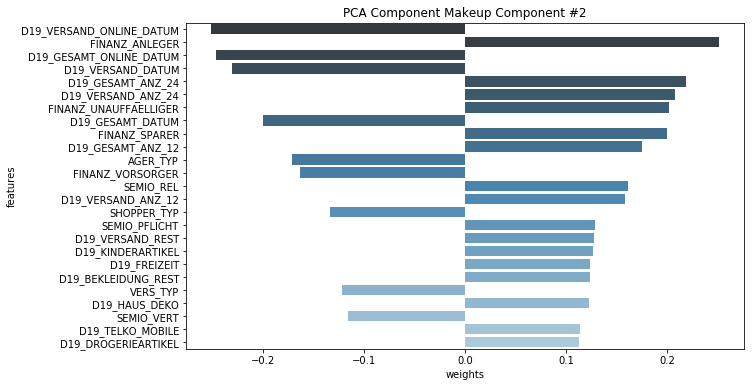

In [22]:
display_component(v, df.columns.values, component_num=2, n_weights=25)

### Deploying the PCA Model

In [ ]:
%%time

pca_predictor = pca.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

In [ ]:
#try chunking data to PCA endpoint
train_pca = []

for chunk in np.array_split(train_data_np, 120):
    train_pca.append(pca_predictor.predict(chunk))

In [ ]:
flattened_train_pca = [list for sublist in train_pca for list in sublist]

In [ ]:
len(flattened_train_pca)

In [ ]:
flattened_train_pca[:1]

In [ ]:
def create_transformed_df(flattened_train_pca, scaled_df, n_top_components):
    start_idx = N_COMPONENTS - n_top_components
    new_values = [x.label['projection'].float32_tensor.values for x in flattened_train_pca]
    df = pd.DataFrame(index=scaled_df.index.values, data=new_values)
    
    top_components = df.iloc[:,start_idx:]
    return top_components.iloc[:,::-1]

In [ ]:
top_n = 10

df_transformed = create_transformed_df(flattened_train_pca, df, n_top_components=top_n)
df_transformed.columns = ['c1', 'c2', 'c3', 'c4', 'c5','c6', 'c7', 'c8', 'c9', 'c10',]
df_transformed.head(10)

In [ ]:
session.delete_endpoint(pca_predictor.endpoint)

In [ ]:
# KMeans

from sagemaker import KMeans

prefix = 'segmentation'
output_path = 's3://{}/{}/'.format(bucket, prefix)
print(output_path)

In [ ]:
kmeans = KMeans(
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    output_path=output_path,
    sagemaker_session=session,
    k=8
)

In [ ]:
train_data_np = df_transformed.values.astype('float32')
formatted_train_data = kmeans.record_set(train_data_np)

In [ ]:
%%time
kmeans.fit(formatted_train_data)

In [ ]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

In [ ]:
%%time
# cluster_info=kmeans_predictor.predict(train_data_np)


#try chunking data to PCA endpoint
cluster_info = []

for chunk in np.array_split(train_data_np, 120):
    cluster_info.append(kmeans_predictor.predict(chunk))

In [ ]:
#explore clusters
data_idx = 0

print(df_transformed.index[data_idx])
cluster_info[data_idx]

In [ ]:
flattened_cluster_info = [list for sublist in cluster_info for list in sublist]

In [ ]:
len(flattened_cluster_info)

In [ ]:
cluster_labels = [c.label['closest_cluster'].float32_tensor.values[0] for c in flattened_cluster_info]

In [ ]:
cluster_df = pd.DataFrame(cluster_labels)[0].value_counts()

print(cluster_df)

In [ ]:
session.delete_endpoint(kmeans_predictor.endpoint)